# Assignment 2

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
from pandas import DataFrame
import matplotlib.pylab as plt
from geopandas import GeoDataFrame

In [4]:
if os.getenv("PUIDATA"):
    data_path = os.getenv("PUIDATA")
else:
    os.system('mkdir data')
    data_path = "./data"

In [5]:
# Download Citibike data
dates = ['201512', '201601', '201602', '201607', '201608', '201609']
data_files = [date + "-citibike-tripdata.zip" for date in dates]

for f in data_files:
    os.system("curl -o " + data_path + "/" + f + " https://s3.amazonaws.com/tripdata/" + f)

In [11]:
# Download Census Tract Files
tract_zip = data_path + "/tracts.zip"

os.system("curl -o " + tract_zip + " http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyct2010_16d.zip")
os.system("unzip " + tract_zip + " -d " + data_path)

0

In [5]:
# Load census tracts and visualize the boroughs
tracts = GeoDataFrame.from_file(data_path + "/nyct2010_16d/nyct2010.shp")
tracts.index=tracts.BoroCT2010

In [6]:
from fiona.crs import from_epsg
tracts.crs = from_epsg(4326)

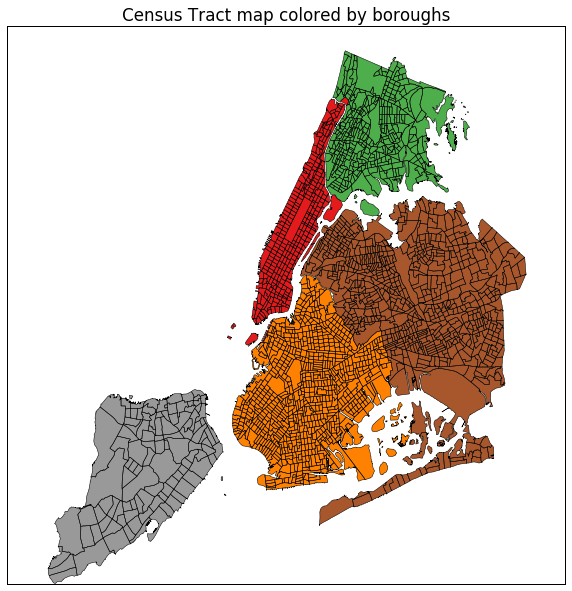

In [97]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
tracts.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Figure 1: Map of Census Tracts in New York City colored by Borough

## Time Series exploration of Citibike Data

In [18]:
summer_files = [date + "-citibike-tripdata.zip" for date in ['201607', '201608', '201609']]
winter_files = [date + "-citibike-tripdata.zip" for date in ['201512', '201601', '201602']]

summer = pd.concat([pd.read_csv(data_path + "/" + file, header=0) for file in summer_files])
winter = pd.concat([pd.read_csv(data_path + "/" + file, header=0) for file in winter_files])

In [20]:
summer.reset_index(drop=True, inplace=True)
winter.reset_index(drop=True, inplace=True)

In [115]:
dfSummer = pd.DataFrame()
dfSummer["id"] = summer["start station id"].value_counts().index
dfSummer["summer"] = summer["start station id"].value_counts().values

In [116]:
dfWinter = pd.DataFrame()
dfWinter["id"] = winter["start station id"].value_counts().index
dfWinter["winter"] = winter["start station id"].value_counts().values

In [62]:
dfStations = pd.concat([winter, summer])

In [63]:
dfStations = dfStations.loc[:, ["start station id", "start station latitude", "start station longitude"]]

In [71]:
dfStations = dfStations[~dfStations.duplicated()]

In [75]:
dfStations.index = dfStations["start station id"]

In [77]:
dfStations.columns = ["id", "lat", "lon"]

In [79]:
dfStations.drop("id", inplace=True, axis=1)

/Users/pichot/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [81]:
import shapely
# combine lat and lon to one column
dfStations['lonlat'] = list(zip(dfStations.lon, dfStations.lat))
# Create Point Geometry for based on lonlat column
dfStations['geometry']=dfStations[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
dfStations.head()

/Users/pichot/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/pichot/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,lat,lon,lonlat,geometry
start station id,,,,
72,40.767272,-73.993929,"(-73.99392888, 40.76727216)",POINT (-73.99392888 40.76727216)
79,40.719116,-74.006667,"(-74.00666661, 40.71911552)",POINT (-74.00666661 40.71911552)
82,40.711174,-74.000165,"(-74.00016545, 40.71117416)",POINT (-74.00016545 40.71117416)
83,40.683826,-73.976323,"(-73.97632328, 40.68382604)",POINT (-73.97632328 40.68382604)
116,40.741776,-74.001497,"(-74.00149746, 40.74177603)",POINT (-74.00149746 40.74177603)


In [101]:
tracts[tracts.geometry.intersects(dfStations.iloc[100].geometry)].BoroCT2010.values

array([], dtype=object)

In [7]:
shape_path="CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010
ct_shape.crs = from_epsg(4326)

In [104]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(dfStations)):
    boro = ct_shape[ct_shape.geometry.intersects(dfStations.iloc[i].geometry)].BoroCT2010.values
    if boro:
        a.append(boro[0])
    else:
        a.append(np.nan)
#     print('\r',"%",str((i+1)*100./len(station_id))[:4])

dfStations['BoroCT2010']=a

/Users/pichot/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [108]:
dfStations.dropna(inplace=True)

/Users/pichot/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [123]:
dfStations = dfStations.merge(dfSummer, left_index=True, right_on="id", how="left")

In [124]:
dfStations = dfStations.merge(dfWinter, left_index=True, right_on="id", how="left")

In [131]:
dfStations["summerAvg"] = dfStations.summer / 3
dfStations["winterAvg"] = dfStations.winter / 3

In [134]:
temp = dfStations[['summerAvg', 'winterAvg']]
temp['station_id'] = dfStations.index
temp.index=dfStations['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

/Users/pichot/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


/Users/pichot/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


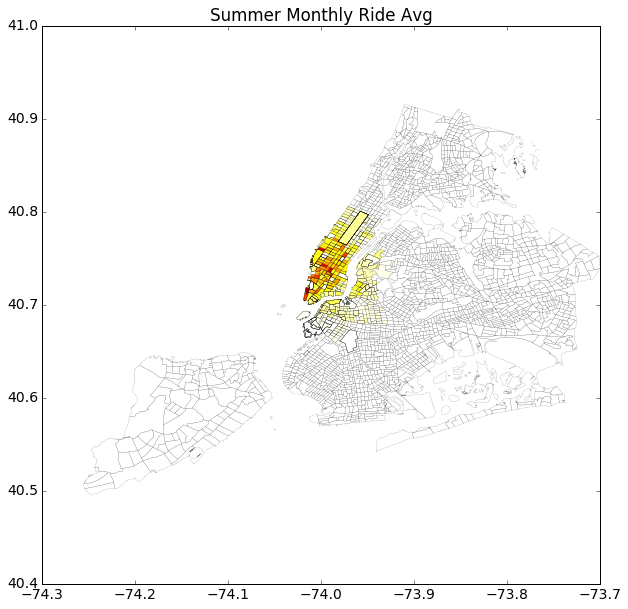

In [136]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='summerAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Monthly Ride Avg")

### Figure 2: Plot of average monthly ridership for July, August, and September 2016

/Users/pichot/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


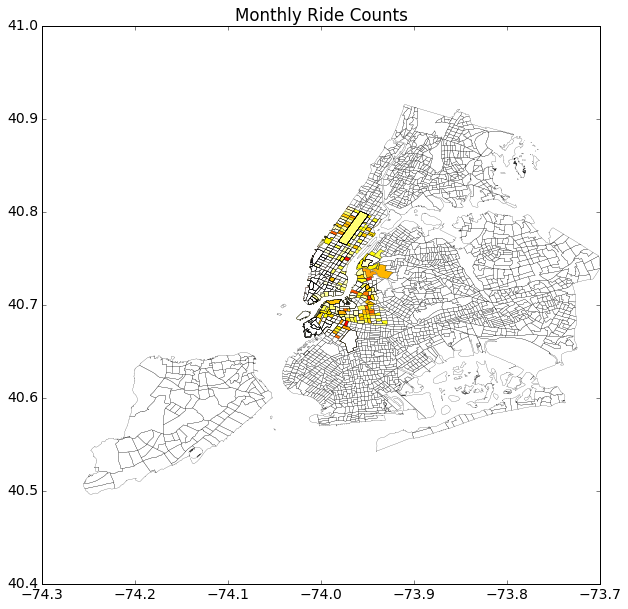

In [135]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='winterAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Monthly Ride Avg")

### Figure 3: Plot of average monthly ridership for December 2015, and January, February 2016

In [137]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [139]:
ct_shape_MonthlyAve_Zoom.to_file(data_path + "/ct_shape_MonthlyAve_Zoom.shp")

## Exploratory Geospatial Analysis

In [140]:
import pysal as ps

In [141]:
qW_CT=ps.queen_from_shapefile(data_path + "/ct_shbape_MonthlyAve_Zoom.shp")

('Island id: ', [0])


In [142]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 31: 1.0, 38: 1.0, 39: 1.0, 40: 1.0}

In [143]:
qW_CT.cardinalities[10]

9

In [144]:
Wmatrix, ids = qW_CT.full()
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [145]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag

In [146]:
SummerRide=ct_shape_MonthlyAve_Zoom.summerAvg
SummerRideLag=ps.lag_spatial(qW_CT, SummerRide)

In [147]:
WinterRide=ct_shape_MonthlyAve_Zoom.winterAvg
WinterRideLag=ps.lag_spatial(qW_CT, WinterRide)

In [148]:
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
SummerRideLagQ10

                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               104
   0.000 < x[i] <=  217.742                63
 217.742 < x[i] <=  401.006                84
 401.006 < x[i] <=  741.285                83
 741.285 < x[i] <= 1260.061                84
1260.061 < x[i] <= 2109.061                83
2109.061 < x[i] <= 2831.204                83
2831.204 < x[i] <= 3944.259                84
3944.259 < x[i] <= 4657.296                83
4657.296 < x[i] <= 6864.048                84

In [149]:
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
WinterRideLagQ10

                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               126
   0.000 < x[i] <=   59.261                41
  59.261 < x[i] <=  219.406                85
 219.406 < x[i] <=  389.752                82
 389.752 < x[i] <=  522.400                84
 522.400 < x[i] <=  682.613                83
 682.613 < x[i] <=  809.960                83
 809.960 < x[i] <= 1034.327                84
1034.327 < x[i] <= 1334.689                83
1334.689 < x[i] <= 2500.367                84

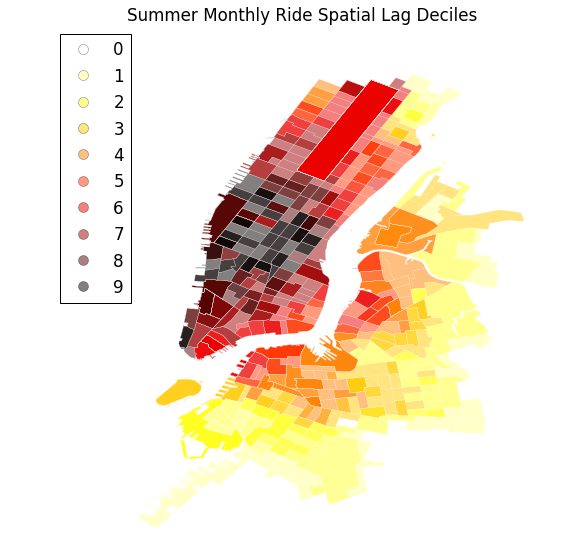

In [153]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Monthly Ride Spatial Lag Deciles")

### Figure 4: Deciles of Average Summer Ridership

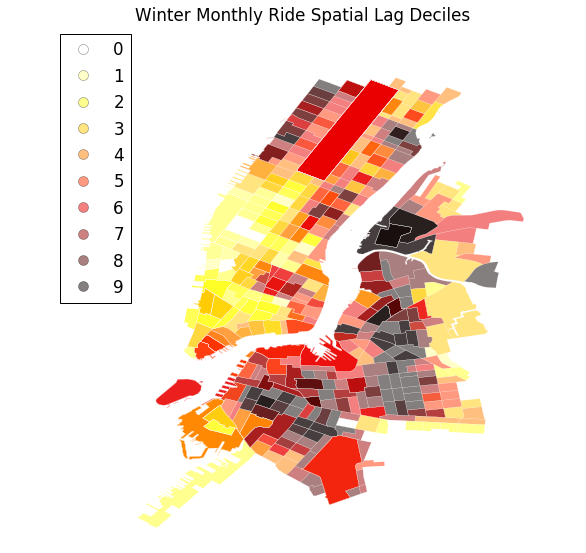

In [152]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Monthly Ride Spatial Lag Deciles")

### Figure 5: Deciles of Average Winter Ridership

In [155]:
bS,aS = np.polyfit(SummerRide, SummerRideLag, 1)
bS,aS

(0.58378911110515785, 827.35022848985193)

In [158]:
bW,aW = np.polyfit(WinterRide, WinterRideLag, 1)
bW,aW

(0.20310453996761385, 476.19947707484471)

## Moran Scatterplot

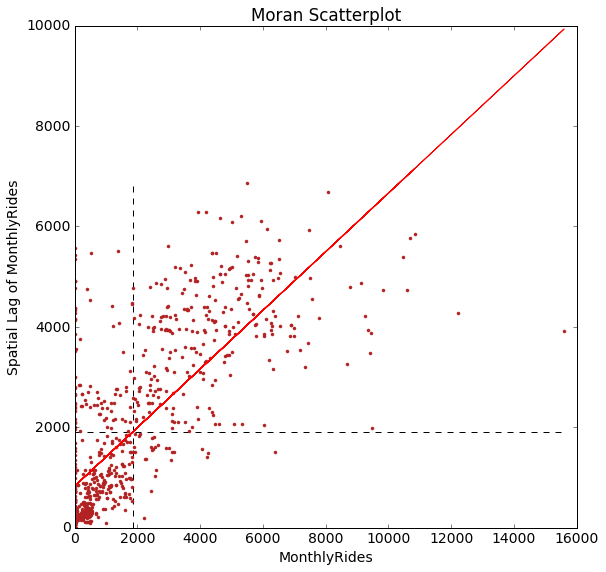

In [159]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(SummerRide, SummerRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, aS + bS*SummerRide, 'r')
plt.title('Moran Scatterplot - Summer')
plt.ylabel('Spatial Lag of Monthly Rides')
plt.xlabel('Monthly Rides')

### Figure 6: Moran scatterplot of summer citibike ridership

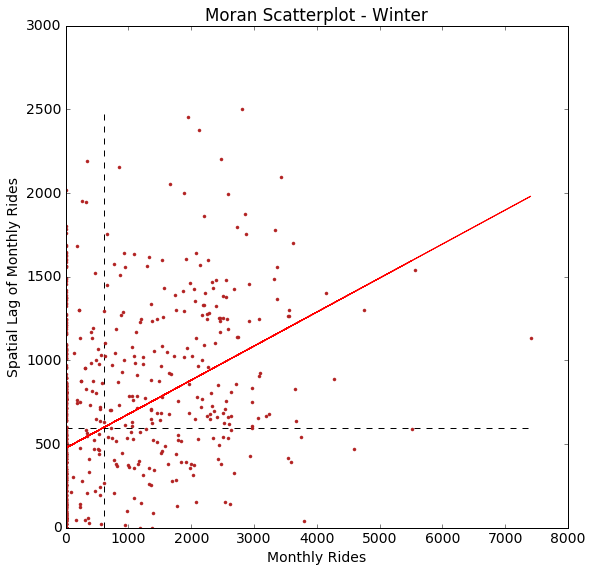

In [161]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(WinterRide, WinterRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, aW + bW*WinterRide, 'r')
plt.title('Moran Scatterplot - Winter')
plt.ylabel('Spatial Lag of Monthly Rides')
plt.xlabel('Monthly Rides')

### Figure 7: Moran scatterplot of winter citibike ridership

## Local Spatial Autocorrelation

In [162]:
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT,permutations=999)
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT,permutations=999)

In [163]:
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

(array([-0.        , -0.16657065,  0.00874285,  0.00196216, -0.03068454]),
 array([ 0.001,  0.263,  0.458,  0.464,  0.373]))

In [164]:
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([-0.        ,  0.05667677, -0.00072403, -0.01230294, -0.02793829]),
 array([ 0.001,  0.448,  0.481,  0.497,  0.374]))

#### Summer Hot and Cold Spots

In [169]:
sig = LMo_SummerRide.p_sim < 0.01
hotspots = LMo_SummerRide.q==1 * sig
coldspots = LMo_SummerRide.q==3 * sig
print("Number of Hotspots:", hotspots.sum())
print("Number of Coldspots:", coldspots.sum())

Number of Hotspots: 191
Number of Coldspots: 228


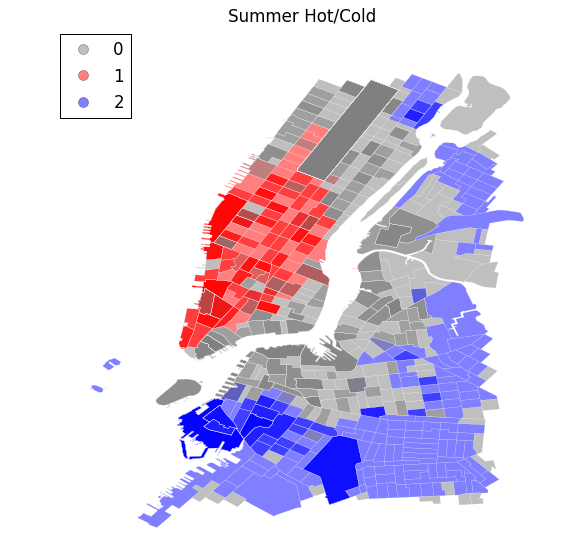

In [170]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Hot/Cold")

### Figure 8: Plot of hot/cold spots for summer ridership

#### Winter Hot and Cold Spots

In [171]:
sig = LMo_WinterRide.p_sim < 0.01
hotspots = LMo_WinterRide.q==1 * sig
coldspots = LMo_WinterRide.q==3 * sig
print("Number of Hotspots:", hotspots.sum())
print("Number of Coldspots:", coldspots.sum())

Number of Hotspots: 39
Number of Coldspots: 69


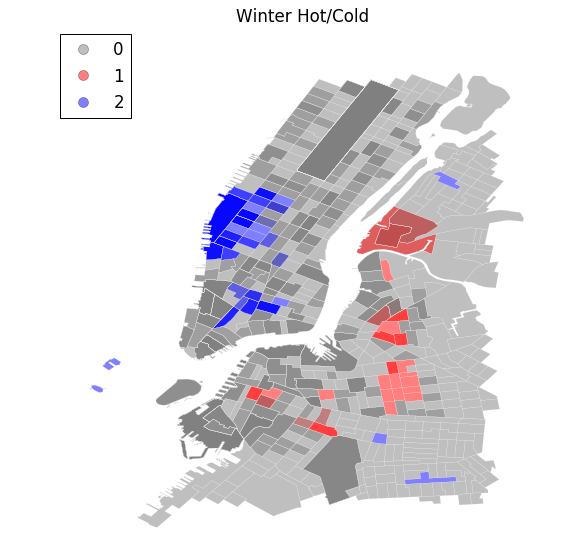

In [173]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Hot/Cold")

### Figure 9: Plot of hot/cold spots for winter ridership